## Error Analysis: what are our false predictions?

- how good is our model with staff pick
- how good is our model without the staff pick? (drop staff pick)
- how good is our model against the staff pick? (predict only staff picked rows)
- how good is out model on data the staff didn't pick

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import os

import src.visualization as vs
import src.process as process
import models.lib as modlib

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

# models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

RSEED = 42

In [8]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Drop Staff Pick

data['day_hour_launch'] = data['day_hour_launch'].astype(str)
data['day_hour_deadline'] = data['day_hour_deadline'].astype(str)
data = data.drop(['staff_pick','usd_pledged','pledge_per_backer'], axis=1)


y = data['state']
X = data.drop('state', axis=1)

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

## Include Staff Pick

Categorical Features: ['country', 'staff_pick', 'usd_type', 'category_name', 'parent_category', 'month_launch', 'weekday_launch', 'day_hour_launch', 'month_deadline', 'weekday_deadline', 'day_hour_deadline'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 3.82 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.84,0.814,0.82,0.845


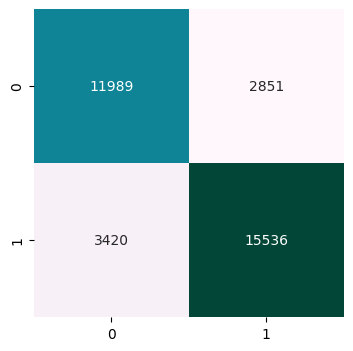

In [9]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Include staff pick

data['day_hour_launch'] = data['day_hour_launch'].astype(str)
data['day_hour_deadline'] = data['day_hour_deadline'].astype(str)
data = data.drop(['usd_pledged','pledge_per_backer'], axis=1)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}

preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')

predictes_y_test_dict, _ = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

## Drop Staff Pick

Categorical Features: ['country', 'usd_type', 'category_name', 'parent_category', 'month_launch', 'weekday_launch', 'day_hour_launch', 'month_deadline', 'weekday_deadline', 'day_hour_deadline'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 3.99 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.818,0.794,0.811,0.82


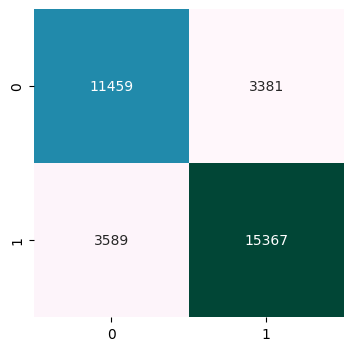

In [10]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Include staff pick

data['day_hour_launch'] = data['day_hour_launch'].astype(str)
data['day_hour_deadline'] = data['day_hour_deadline'].astype(str)
data = data.drop(['staff_pick','usd_pledged','pledge_per_backer'], axis=1)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}

preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')

predictes_y_test_dict, _ = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

,FBeta,Accuracy,Recall,Precision
scaledXGB,0.818,0.794,0.811,0.82


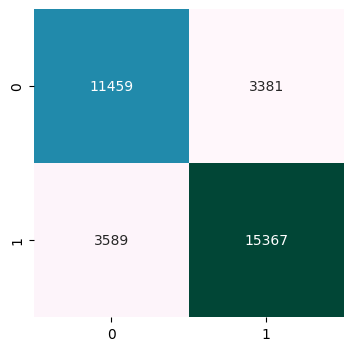

In [11]:
og_predictions = {}
scaled_models['scaledXGB'].fit(X_train, y_train)
og_predictions['scaledXGB'] = scaled_models['scaledXGB'].predict(X_test_og)

display(vs.nice_scores(y_test_og, og_predictions))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_og, og_predictions['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

In [12]:
data_with_predictions = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), pd.Series(predictes_y_test_dict['scaledXGB'], name='predictions').reset_index(drop=True)], axis=1)

prediction_errors = data_with_predictions.query('state != predictions')
prediction_errors.to_csv(os.path.join('data/processed/', 'kickstarter_errors.csv'), index=False)
prediction_errors

,country,usd_type,converted_goal,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month_launch,weekday_launch,day_hour_launch,month_deadline,weekday_deadline,day_hour_deadline,state,predictions
8,US,domestic,1600.00,20.0,7,Software,technology,2592000,1311216,November,Tuesday,1,December,Thursday,1,1,0
16,US,international,6000.00,18.0,7,Jewelry,fashion,2592000,1521100,June,Friday,17,July,Sunday,17,1,0
18,US,domestic,1100.00,22.0,7,Video Art,art,4231552,574282,January,Sunday,17,March,Sunday,17,0,1
20,US,domestic,3500.00,8.0,4,Electronic Music,music,3570556,4235322,April,Monday,23,May,Monday,6,0,1
21,US,international,7500.00,21.0,7,Makerspaces,technology,2588400,588034,February,Tuesday,18,March,Thursday,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33771,GB,domestic,50204.02,18.0,8,Sound,technology,3884400,3409802,February,Saturday,21,April,Tuesday,20,1,0
33773,US,international,15000.00,22.0,5,Plays,theater,2613528,1072622,November,Saturday,23,December,Tuesday,4,0,1
33781,CA,international,77384.41,24.0,9,Restaurants,food,2592000,2022073,September,Friday,15,October,Sunday,15,1,0
33794,US,international,5000.00,18.0,4,Puzzles,games,4527383,1667291,October,Tuesday,19,November,Saturday,4,1,0


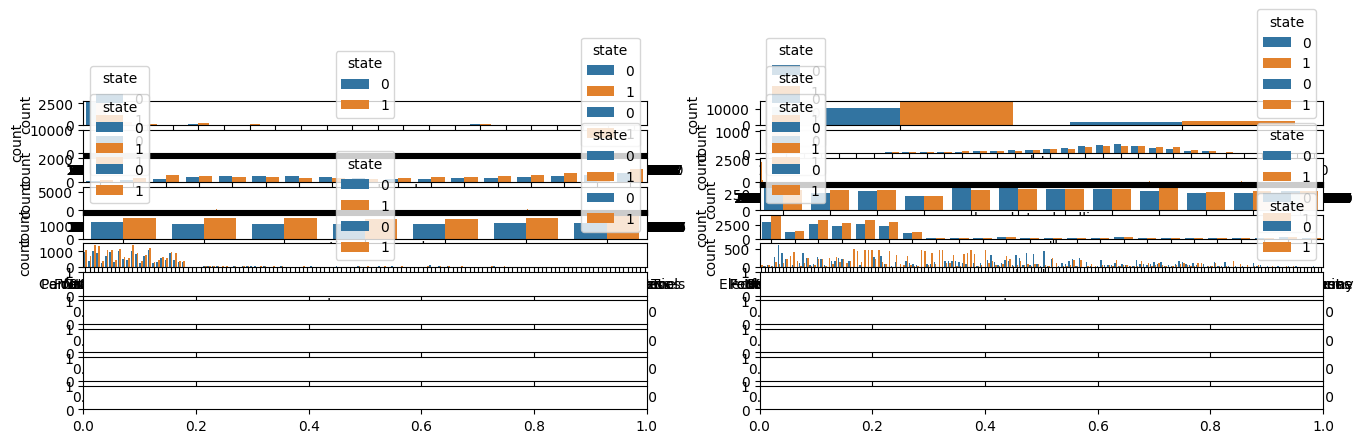

In [8]:
j=len(X_test.columns)
fig, axs = plt.subplots(ncols=2,nrows=j,figsize=(16, 4)) 
for k, column in enumerate(X_test.columns):
    

    sns.countplot(data=prediction_errors, x=column, ax=axs.flat[k], hue='state')
    sns.countplot(data=X_test, x=column, ax=axs.flat[k+1], hue=y_test)

In [13]:
vs.nice_summary(prediction_errors)

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,country,object,21,6970,-,-,0,-,-,-,-,-,-,-
1,usd_type,object,2,6968,2,0.03,0,-,-,-,-,-,-,-
2,converted_goal,float64,2396,6970,-,-,0,11327.37,39467.6,1.0,1500.0,4420.12,10500.0,2000000.0
3,len_blurb,float64,32,6970,-,-,0,19.04,4.84,1.0,17.0,20.0,22.0,32.0
4,len_name,int64,15,6970,-,-,0,5.87,2.65,1.0,4.0,6.0,8.0,15.0
5,category_name,object,132,6970,-,-,0,-,-,-,-,-,-,-
6,parent_category,object,15,6970,-,-,0,-,-,-,-,-,-,-
7,launch_to_deadline,int64,2123,6970,-,-,0,2785474.16,959157.08,117393.0,2588400.0,2592000.0,2858850.75,7948800.0
8,creation_to_launch,int64,6951,6970,-,-,0,4136967.14,10234325.83,402.0,305418.25,1075346.0,3484901.75,207422363.0
9,month_launch,object,12,6970,-,-,0,-,-,-,-,-,-,-


## Only Staff Picked Data

Categorical Features: ['country', 'usd_type', 'category_name', 'parent_category', 'month_launch', 'weekday_launch', 'day_hour_launch', 'month_deadline', 'weekday_deadline', 'day_hour_deadline'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 0.69 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.918,0.895,0.99,0.902


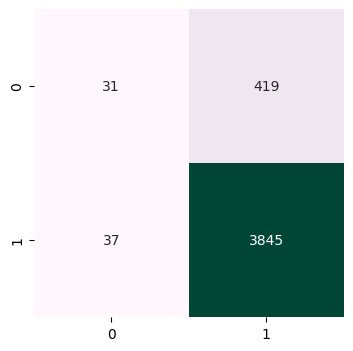

In [15]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Include staff pick

data['day_hour_launch'] = data['day_hour_launch'].astype(str)
data['day_hour_deadline'] = data['day_hour_deadline'].astype(str)
data = data.drop(['usd_pledged','pledge_per_backer'], axis=1)


# Drop all Rows where staff pick == False, then drop staff pick

data = data.drop(data[data['staff_pick'] == False].index)
data = data.drop(['staff_pick'], axis=1)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)


target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}


preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')


predictes_y_test_dict, _ = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

In [16]:
from imblearn.over_sampling import SMOTE

# Choose an oversampling method
oversampler = SMOTE(random_state=RSEED)

# Apply oversampling to the training set
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'US'

,FBeta,Accuracy,Recall,Precision
scaledXGB,0.641,0.607,0.996,0.589


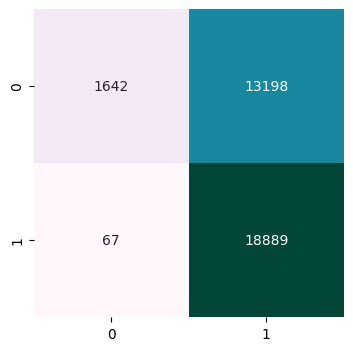

In [16]:
og_predictions = {}
scaled_models['scaledXGB'].fit(X_train, y_train)
og_predictions['scaledXGB'] = scaled_models['scaledXGB'].predict(X_test_og)

display(vs.nice_scores(y_test_og, og_predictions))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_og, og_predictions['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

## Only non-Staff Picked Data

Categorical Features: ['country', 'usd_type', 'category_name', 'parent_category', 'month_launch', 'weekday_launch', 'day_hour_launch', 'month_deadline', 'weekday_deadline', 'day_hour_deadline'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']
scaledXGB - Time taken: 3.37 seconds


,FBeta,Accuracy,Recall,Precision
scaledXGB,0.818,0.805,0.782,0.828


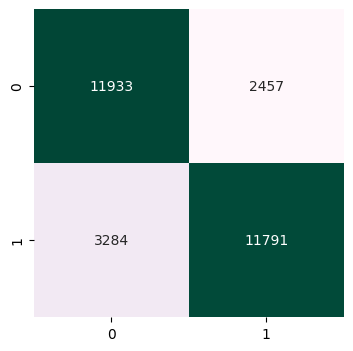

In [17]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')


# Include staff pick

data['day_hour_launch'] = data['day_hour_launch'].astype(str)
data['day_hour_deadline'] = data['day_hour_deadline'].astype(str)
data = data.drop(['usd_pledged','pledge_per_backer'], axis=1)


# Drop all Rows where staff pick == True

data = data.drop(data[data['staff_pick'] == True].index)
data = data.drop(['staff_pick'], axis=1)

y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)


target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = {'XGB':  XGBClassifier(seed=RSEED)}


preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')


predictes_y_test_dict, _ = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, predictes_y_test_dict['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

,FBeta,Accuracy,Recall,Precision
scaledXGB,0.839,0.798,0.762,0.861


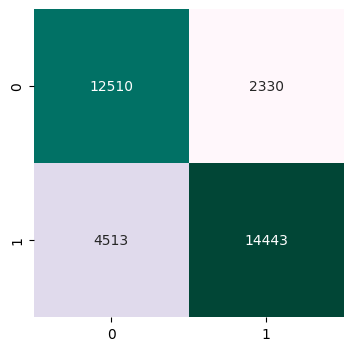

In [18]:
og_predictions = {}
scaled_models['scaledXGB'].fit(X_train, y_train)
og_predictions['scaledXGB'] = scaled_models['scaledXGB'].predict(X_test_og)

display(vs.nice_scores(y_test_og, og_predictions))

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test_og, og_predictions['scaledXGB']), fmt='g', annot=True, cmap='PuBuGn', cbar=False);

- make a table that only contains falsely predicted rows
- compare data distributions of falsely predicted vs entire data